# Riduzione di dimensionalità mediante LDA

In [73]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [142]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import scipy.linalg as la
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn.apionly as sns

In [75]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

Legge dataset

In [76]:
df = pd.read_csv("../../data/iris.csv", header=0, delimiter=';')

In [77]:
df.head()

,petal_length,petal_width,sepal_length,sepal_width,class
0,1.4,0.2,5.1,3.5,setosa
1,1.4,0.2,4.9,3.0,setosa
2,1.3,0.2,4.7,3.2,setosa
3,1.5,0.2,4.6,3.1,setosa
4,1.4,0.2,5.0,3.6,setosa


Deriva matrice delle feature e vettore target

In [78]:
X = np.array(df[df.columns[:-1]])
y = np.array(df[df.columns[-1]])

Codifica le classi come interi

In [79]:
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {label_encoder.transform(['setosa'])[0]+1: 'Setosa', 
              label_encoder.transform(['versicolor'])[0]+1: 'Versicolor', 
              label_encoder.transform(['virginica'])[0]+1:'Virginica'}

Matrice delle distribuzioni mutue delle feature. Sulla diagonale, distribuzione delle singole feature

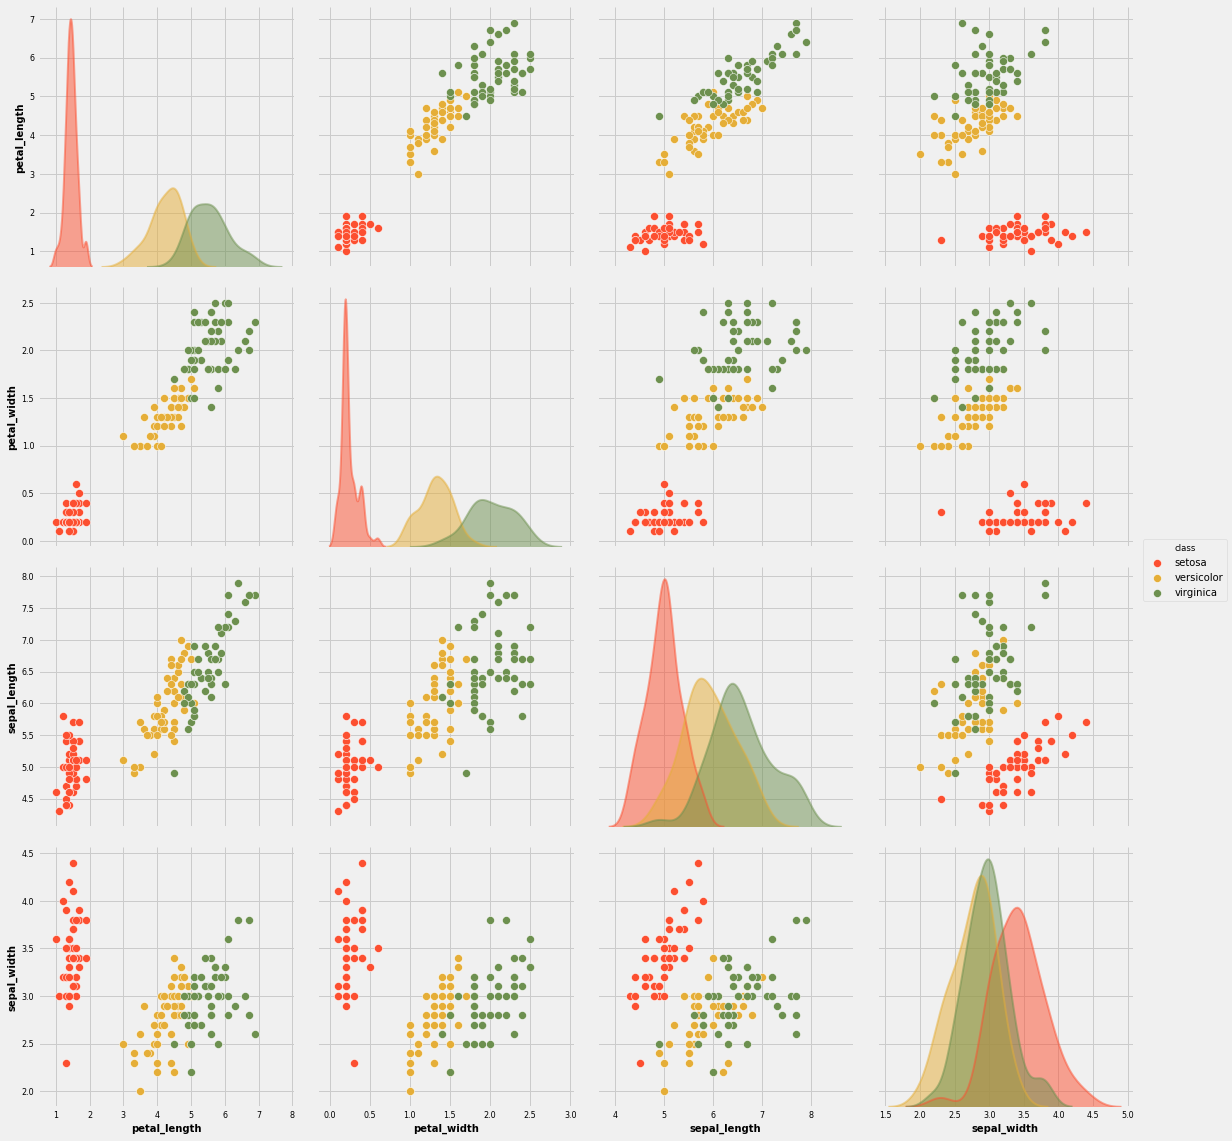

In [162]:
fig = plt.figure(figsize=(16, 8))
sns.pairplot(df, size=4, diag_kind='kde', hue='class', palette={'setosa': colors[1], 'versicolor': colors[2], 'virginica':colors[3]},
             diag_kws=dict(shade=True, alpha=.5))
plt.show()

Valori medi delle feature per tutte le classi

In [64]:
mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Class {0:s}: {1:s}'.format(label_dict[cl], mean_vectors[cl-1]))

Class Setosa: [1.462 0.246 5.006 3.428]
Class Versicolor: [4.26  1.326 5.936 2.77 ]
Class Virginica: [5.552 2.026 6.588 2.974]


Deriva scatter matrix within classes

In [115]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    Xp = X[y == cl]
    S_W += np.dot((Xp-mv).T,(Xp-mv))
print('Within-class Scatter Matrix:\n')
print('{0:s}'.format(S_W))

Within-class Scatter Matrix:

[[27.2226  6.2718 24.6246  8.1208]
 [ 6.2718  6.1566  5.645   4.8084]
 [24.6246  5.645  38.9562 13.63  ]
 [ 8.1208  4.8084 13.63   16.962 ]]


Deriva scatter matrix between classes

In [116]:
overall_mean = np.mean(X, axis=0)
S_B = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    n = X[y==c1].shape[0]
    cv = (mv-overall_mean).reshape(1,-1)
    S_B += n*np.dot(cv.T,cv)
print('Between-class Scatter Matrix:\n')
print('{0:s}'.format(S_B))

Between-class Scatter Matrix:

[[437.1028 186.774  165.2484 -57.2396]
 [186.774   80.4133  71.2793 -22.9327]
 [165.2484  71.2793  63.2121 -19.9527]
 [-57.2396 -22.9327 -19.9527  11.3449]]


Calcola autovalori e autovettori di $S_W^{-1}S_B$

In [125]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('Autovalore {0:d}: {1:.2e}.  Autovettore {2:s}'.format(i+1, eig_vals[i].real, eigvec_sc.real.reshape(1,-1)))

Autovalore 1: 3.22e+01.  Autovettore [[-0.554  -0.7074  0.2087  0.3862]]
Autovalore 2: 2.85e-01.  Autovettore [[-0.2526  0.7695  0.0065  0.5866]]
Autovalore 3: 3.46e-15.  Autovettore [[-0.3758  0.7164  0.0747 -0.3167]]
Autovalore 4: 3.46e-15.  Autovettore [[-0.3758  0.7164  0.0747 -0.3167]]


Ordina le coppie autovalore-autovettore in ordine decrescente nel modulo dell'autovalore

In [127]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

In [129]:
print('Varianza descritta dagli autovalori:')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('Autovalore {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Varianza descritta dagli autovalori:
Autovalore 1: 99.12%
Autovalore 2: 0.88%
Autovalore 3: 0.00%
Autovalore 4: 0.00%


Deriva la matrice di proiezione sull'iperpiano definito dai primi new_dim autovettori

In [139]:
new_dim = 2
W = eig_pairs[0][1].reshape(4,1)
for i in range(1, new_dim):
    W = np.hstack((W, eig_pairs[i][1].reshape(4,1)))
print('Matrice di proiezione W:')
print(W.real)

Matrice di proiezione W:
[[-0.554  -0.2526]
 [-0.7074  0.7695]
 [ 0.2087  0.0065]
 [ 0.3862  0.5866]]


Proietta gli elementi nel nuovo spazio

In [25]:
X_lda = X.dot(W)

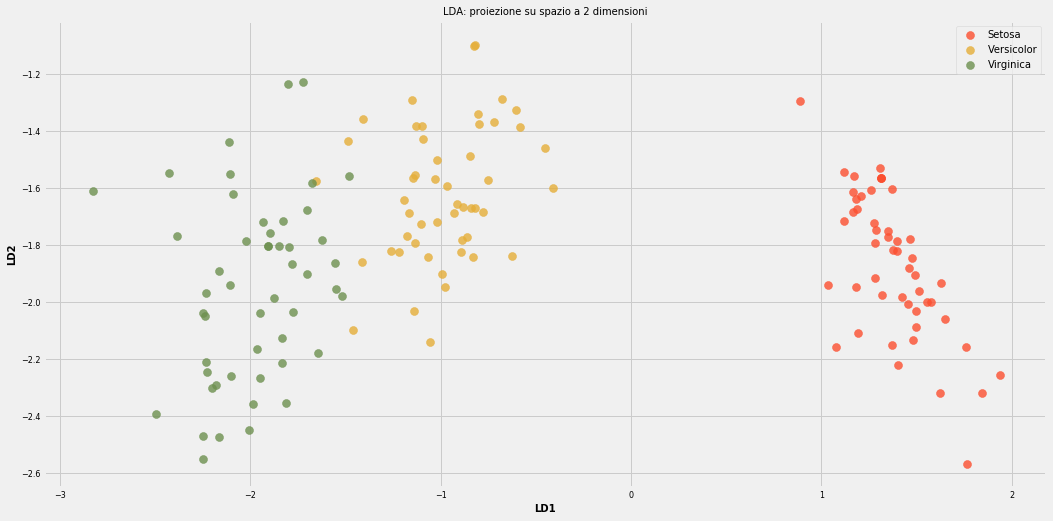

In [145]:
fig = plt.figure(figsize=(16,8))
for label in range(1,4):
    plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                color=colors[label],
                alpha=0.8,
                label=label_dict[label])
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='upper right', fancybox=True)
plt.title('LDA: proiezione su spazio a 2 dimensioni')   
plt.show()

Utilizza la funzione in scikit-learn

In [146]:
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

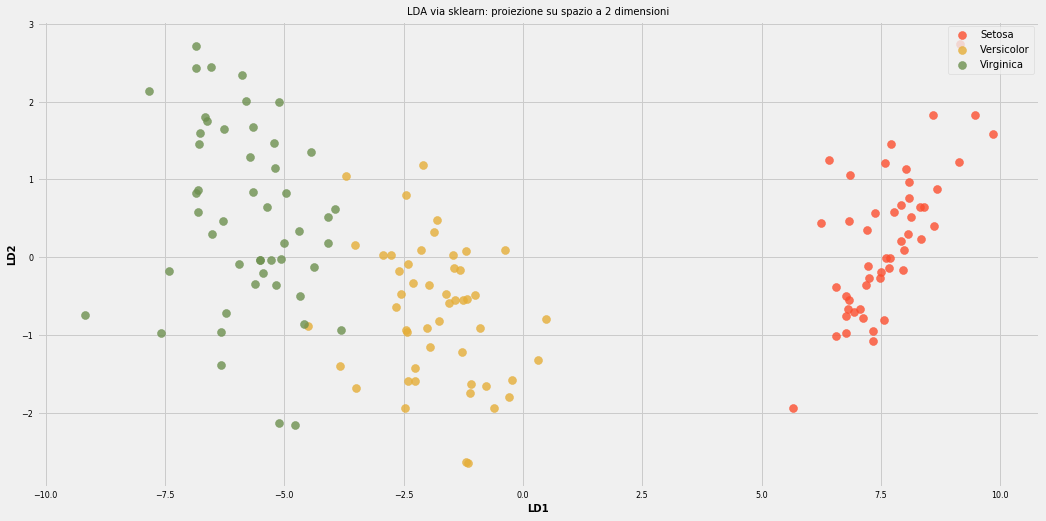

In [147]:
fig = plt.figure(figsize=(16,8))
for label in range(1,4):
    plt.scatter(x=X_lda_sklearn[:,0][y == label],
                y=X_lda_sklearn[:,1][y == label] * -1,
                color=colors[label],
                alpha=0.8,
                label=label_dict[label])
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='upper right', fancybox=True)
plt.title('LDA via sklearn: proiezione su spazio a 2 dimensioni')
plt.show()